In [ ]:
import os
import git
from pathlib import Path

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
main_df = main_df.copy()
RERUN=False
np.random.seed(0)

In [3]:
main_df.groupby(['dataset', 'transform']).agg({'pass_kurt_intersect_hull' : 'sum', 'pass_kurt_anywhere' : 'sum', 'group' : 'size'}).rename({'group' : 'total_hulls'}, axis=1)

pass_kurt_intersect_hull pass_kurt_anywhere  \
dataset         transform                                               
agriVision      fourier                          0                  0   
                learned                          0                  5   
                wavelet                          0                  4   
coco            learned                         23                 87   
                wavelet                          0                 77   
pastis          fourier                          0                 18   
                learned                          4                 21   
                wavelet                          3                 21   
segmentAnything learned                         18                 56   
                wavelet                         11                 46   
spaceNet        fourier                          2                  7   
                learned                          3                 36   
                wavelet                          1                 15   
standardTesting learned                          1                 31   
                wavelet                          0                  8   
syntheticMRI2D  wavelet                          0                 11   
syntheticMRI3D  wavelet                          0                  6   

                           total_hulls  
dataset         transform               
agriVision      fourier             44  
                learned             60  
                wavelet             72  
coco            learned            126  
                wavelet            192  
pastis          fourier             44  
                learned             35  
                wavelet             56  
segmentAnything learned             64  
                wavelet            108  
spaceNet        fourier             32  
                learned             56  
                wavelet             64  
standardTesting learned             54  
                wavelet             27  
syntheticMRI2D  wavelet             66  
syntheticMRI3D  wavelet             42

In [4]:
main_df.groupby(['dataset', 'transform']).agg({'pass_kurt_intersect_hull' : 'mean', 'pass_kurt_anywhere' : 'mean'}).astype(float).round(3) * 100

pass_kurt_intersect_hull  pass_kurt_anywhere
dataset         transform                                              
agriVision      fourier                         0.0                 0.0
                learned                         0.0                 8.3
                wavelet                         0.0                 5.6
coco            learned                        18.3                69.0
                wavelet                         0.0                40.1
pastis          fourier                         0.0                40.9
                learned                        11.4                60.0
                wavelet                         5.4                37.5
segmentAnything learned                        28.1                87.5
                wavelet                        10.2                42.6
spaceNet        fourier                         6.2                21.9
                learned                         5.4                64.3
                wavelet                         1.6                23.4
standardTesting learned                         1.9                57.4
                wavelet                         0.0                33.3
syntheticMRI2D  wavelet                         0.0                17.5
syntheticMRI3D  wavelet                         0.0                14.3

In [5]:
, 'group' : 'size'}).rename({'group' : 'total_hulls'}, axis=1

("'group'", ':', "'size'}).rename({'group'", ':', "'total_hulls'},", 'axis=1')

In [6]:
main_df.groupby(['dataset', 'transform']).agg({'pass_kurt_intersect_hull' : 'mean', 'pass_kurt_anywhere' : 'mean', 'group' : 'size'}).rename({'group' : 'total_hulls'}, axis=1).astype(float).round(3) * 100

pass_kurt_intersect_hull  pass_kurt_anywhere  \
dataset         transform                                                 
agriVision      fourier                         0.0                 0.0   
                learned                         0.0                 8.3   
                wavelet                         0.0                 5.6   
coco            learned                        18.3                69.0   
                wavelet                         0.0                40.1   
pastis          fourier                         0.0                40.9   
                learned                        11.4                60.0   
                wavelet                         5.4                37.5   
segmentAnything learned                        28.1                87.5   
                wavelet                        10.2                42.6   
spaceNet        fourier                         6.2                21.9   
                learned                         5.4                64.3   
                wavelet                         1.6                23.4   
standardTesting learned                         1.9                57.4   
                wavelet                         0.0                33.3   
syntheticMRI2D  wavelet                         0.0                17.5   
syntheticMRI3D  wavelet                         0.0                14.3   

                           total_hulls  
dataset         transform               
agriVision      fourier         4400.0  
                learned         6000.0  
                wavelet         7200.0  
coco            learned        12600.0  
                wavelet        19200.0  
pastis          fourier         4400.0  
                learned         3500.0  
                wavelet         5600.0  
segmentAnything learned         6400.0  
                wavelet        10800.0  
spaceNet        fourier         3200.0  
                learned         5600.0  
                wavelet         6400.0  
standardTesting learned         5400.0  
                wavelet         2700.0  
syntheticMRI2D  wavelet         6600.0  
syntheticMRI3D  wavelet         4200.0

In [7]:
fontsize = 15
markersize = 10
labelsize = 15
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
]

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

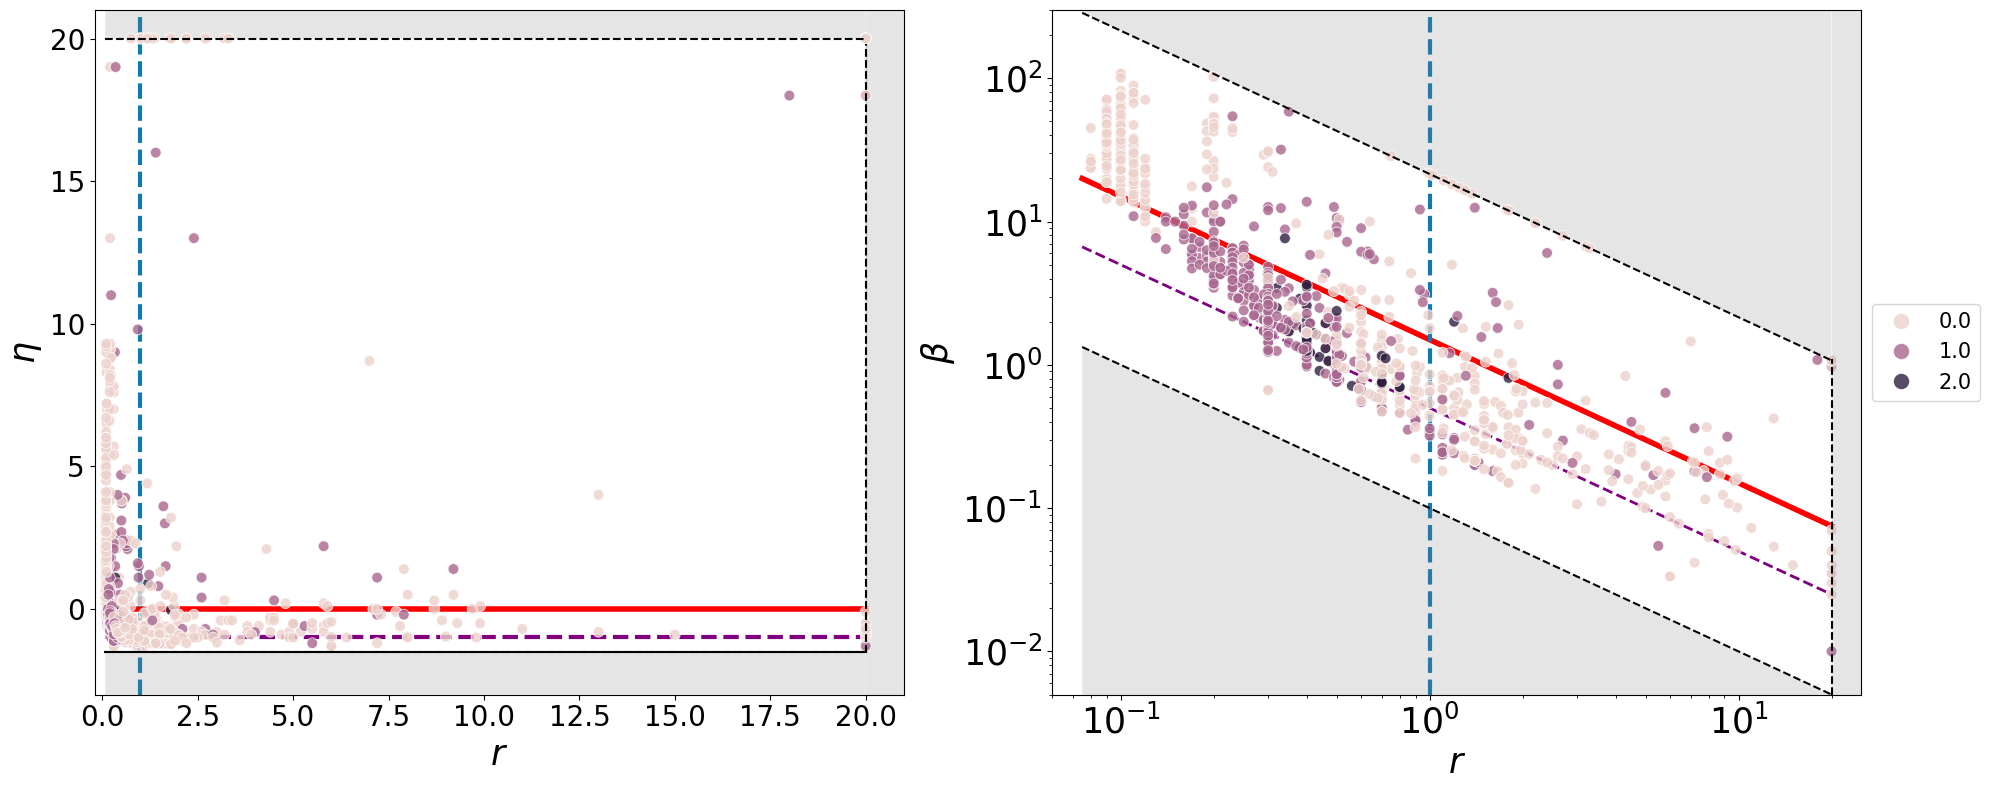

In [ ]:
temp = main_df.copy()
temp['kurt_map'] = np.nan_to_num(temp['pass_kurt_anywhere'] + temp['pass_kurt_intersect_hull'])

fontsize=25
r_valid = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_valid = (-1.5, 20)
xlims = (r_valid[0] - 0.1, r_valid[1] + 0.1)
eta_lims = (-3, 21)
ylims = (eta_valid[0] - 0.1, eta_valid[1] + 0.1)

r_roi = (temp['best_r'].min() - 0.5, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = (1.5 + eta_valid[1]) / r_vals
beta_vals_below = (1.5 + (-1.4)) / r_vals

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
r_vals_roi = np.where(r_vals_roi == 0, 1e-10, r_vals_roi)  # Replace zero with a small positive value
beta_vals_roi_above = (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = beta_border

# Plot the Region of Interest in all 4 plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle("Pass Kurtosis + Intersect Region of Best Fit")

# First plot (left): r-eta space with failure categories
axes[0].fill_between(r_vals, y1=eta_lims[0], y2=eta_valid[0], color='gray', alpha=0.2, ec=None)
axes[0].fill_between(r_vals, y1=eta_valid[1], y2 = 21, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=0, color='red', ax=axes[0], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=-1, color='purple', ax=axes[0], linestyle='--', linewidth=3, zorder=0)
sns.lineplot(x=[20, 20], y=[-1.5, 20], color='black', ax=axes[0], linestyle='--')
axes[0].axvline(x=20, ymin=0.06, ymax=0.95, color='black', linestyle='dashed')
axes[0].fill_betweenx(y=eta_lims, x1=20, x2=25, color='gray', alpha=0.2, ec=None)

axes[0].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', alpha=1, linewidth=3, zorder=0)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0])
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0], linestyle="--")
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0], linestyle="--")
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='kurt_map', ax=axes[0], alpha=0.8, s=60)

# axes[0].set_title(r'Best fit $r, \eta$ categorized by passing', fontsize=20)
axes[0].set_xlabel(r"$r$", fontsize=25)
axes[0].set_ylabel(r'$\eta$', fontsize=25)
axes[0].set_ylim(eta_lims)
axes[0].set_xlim((-0.2, 21))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].legend(markerscale=1.5, fontsize=10, loc='center right').set_visible(False)

# Second plot (right): r-(1/beta) space with failure categories
axes[1].fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1], linestyle="--")
axes[1].fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+100, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=axes[1], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=axes[1], linestyle='--', linewidth=2, zorder=0)
axes[1].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='kurt_map', ax=axes[1], alpha=0.8, s=60)
axes[1].axvline(x=20.1, ymax=0.49, color='black', linestyle='dashed')
axes[1].fill_betweenx(y=[-1.4, 300], x1=20, x2=300, color='gray', alpha=0.2, ec=None)

# axes[1].set_title(r'Best fit $r, \beta$ categorized by passing', fontsize=20)
axes[1].set_xlabel(r"$r$", fontsize=fontsize)
axes[1].set_ylabel(r'$\beta$', fontsize=fontsize)
axes[1].set_xlim((0.06, 25))
axes[1].set_ylim((0.005, 300))
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
axes[1].legend(markerscale=1.5, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "kurtosis_best_r_eta_beta_panel_plot.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

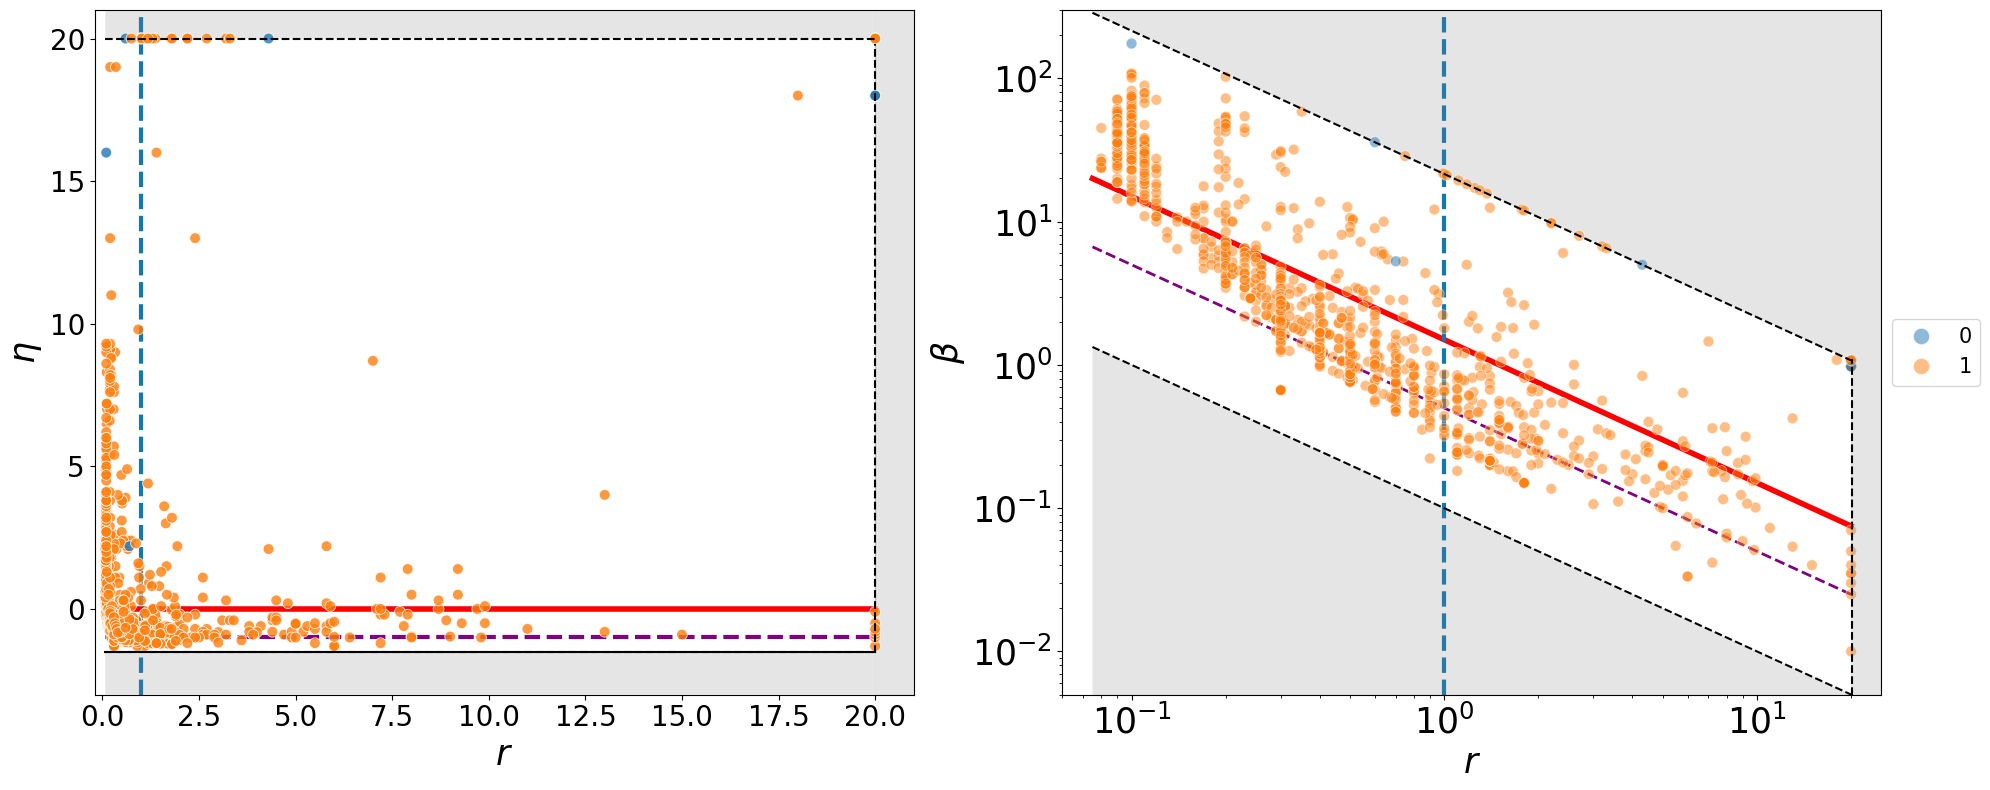

In [ ]:
temp = main_df.copy()
fontsize=25
r_valid = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_valid = (-1.5, 20)
xlims = (r_valid[0] - 0.1, r_valid[1] + 0.1)
eta_lims = (-3, 21)
ylims = (eta_valid[0] - 0.1, eta_valid[1] + 0.1)

r_roi = (temp['best_r'].min() - 0.5, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = (1.5 + eta_valid[1]) / r_vals
beta_vals_below = (1.5 + (-1.4)) / r_vals

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
r_vals_roi = np.where(r_vals_roi == 0, 1e-10, r_vals_roi)  # Replace zero with a small positive value
beta_vals_roi_above = (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = beta_border

# Plot the Region of Interest in all 4 plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle("Intersect ROI")

# First plot (left): r-eta space with failure categories
axes[0].fill_between(r_vals, y1=eta_lims[0], y2=eta_valid[0], color='gray', alpha=0.2, ec=None)
axes[0].fill_between(r_vals, y1=eta_valid[1], y2 = 21, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=0, color='red', ax=axes[0], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=-1, color='purple', ax=axes[0], linestyle='--', linewidth=3, zorder=0)
sns.lineplot(x=[20, 20], y=[-1.5, 20], color='black', ax=axes[0], linestyle='--')
axes[0].axvline(x=20, ymin=0.06, ymax=0.95, color='black', linestyle='dashed')
axes[0].fill_betweenx(y=eta_lims, x1=20, x2=25, color='gray', alpha=0.2, ec=None)

axes[0].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', alpha=1, linewidth=3, zorder=0)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0])
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0], linestyle="--")
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0], linestyle="--")
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='intersect_roi', ax=axes[0], alpha=0.8, s=60)

# axes[0].set_title(r'Best fit $r, \eta$ categorized by passing', fontsize=20)
axes[0].set_xlabel(r"$r$", fontsize=25)
axes[0].set_ylabel(r'$\eta$', fontsize=25)
axes[0].set_ylim(eta_lims)
axes[0].set_xlim((-0.2, 21))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].legend(markerscale=1.5, fontsize=10, loc='center right').set_visible(False)

# Second plot (right): r-(1/beta) space with failure categories
axes[1].fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1], linestyle="--")
axes[1].fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+100, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=axes[1], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=axes[1], linestyle='--', linewidth=2, zorder=0)
axes[1].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='intersect_roi', ax=axes[1], alpha=0.5, s=60)
axes[1].axvline(x=20.1, ymax=0.49, color='black', linestyle='dashed')
axes[1].fill_betweenx(y=[-1.4, 300], x1=20, x2=300, color='gray', alpha=0.2, ec=None)

# axes[1].set_title(r'Best fit $r, \beta$ categorized by passing', fontsize=20)
axes[1].set_xlabel(r"$r$", fontsize=fontsize)
axes[1].set_ylabel(r'$\beta$', fontsize=fontsize)
axes[1].set_xlim((0.06, 25))
axes[1].set_ylim((0.005, 300))
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
axes[1].legend(markerscale=1.5, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "failure_type_best_r_eta_beta_panel_plot.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

In [19]:
main_df['intersect_roi'].value_counts()

intersect_roi
1    1136
0       6
Name: count, dtype: int64

In [11]:
# Extract labels and handles from the figure
handles, labels = axes[0].get_legend_handles_labels()
labels = [l.replace("_", " ") for l in labels]
handles = ['pass_kurt_intersect_hull', 'pass_kurt_outside_hull', 'none']

C:\Users\yashd\AppData\Local\Temp\ipykernel_15648\3073803862.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend_fig.legend(handles=handles, labels=labels, loc='center', ncol=6, fontsize=12)


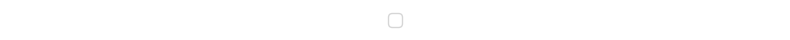

In [12]:
desired_order = ['pass_kurt_intersect_hull', 'pass_kurt_outside_hull', 'none']
label_handle_map = dict(zip(labels, handles))

labels = [label for label in desired_order if label in label_handle_map]
handles = [label_handle_map[label] for label in labels]

legend_fig = plt.figure(figsize=(8, 0.5))
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')  # Turn off the axis

legend_fig.legend(handles=handles, labels=labels, loc='center', ncol=6, fontsize=12)

plt.tight_layout()
plt.show()


if SAVE_FIGS:
    legend_save_path = os.path.join(plots_path, "failure_type_legend.jpg")
    legend_fig.savefig(legend_save_path, dpi=600, bbox_inches='tight')